# Chapter 7: The autoregressive moving average (ARMA) model



### 7.1. Time series basics
> ###### 7.1.1. Trend, cycle, seasonality
> ###### 7.1.2.  Log prices properties
> ###### 7.1.3. The linear regression
### 7.2. AR and MA models
> ###### 7.2.1. Autoregressor model (AR)
> ###### 7.2.2. Moving average model (MA)
### 7.3. ARMAs models
> ###### 7.3.1. ARMA model
> ###### 7.3.2. ARIMA model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from Backtest import *

### 7.1.1. Trend, cycle, seasonality

[*********************100%***********************]  1 of 1 completed


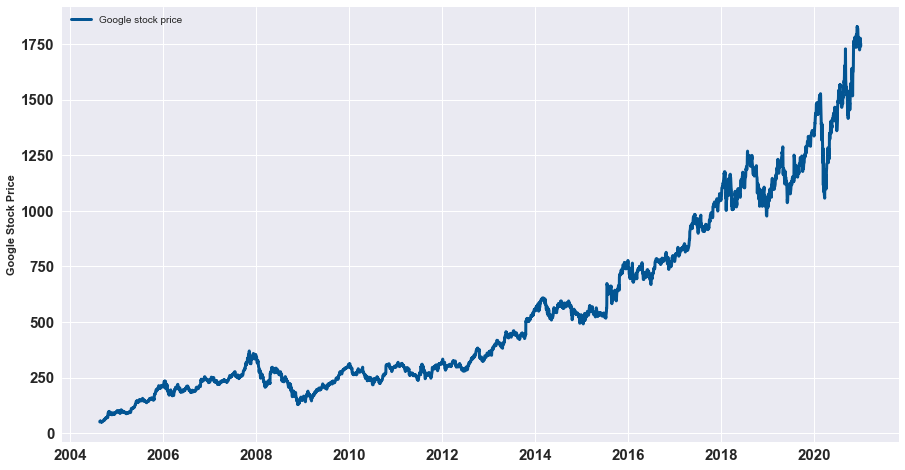

In [2]:
# TRENDING TIME SERIES 
# Import google stock price data
goog = yf.download("GOOG",end="2021-01-01")



# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(goog["Close"], color="#035593", linewidth=3)
plt.ylabel("Google Stock Price",fontweight="bold")
plt.legend(["Google stock price"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

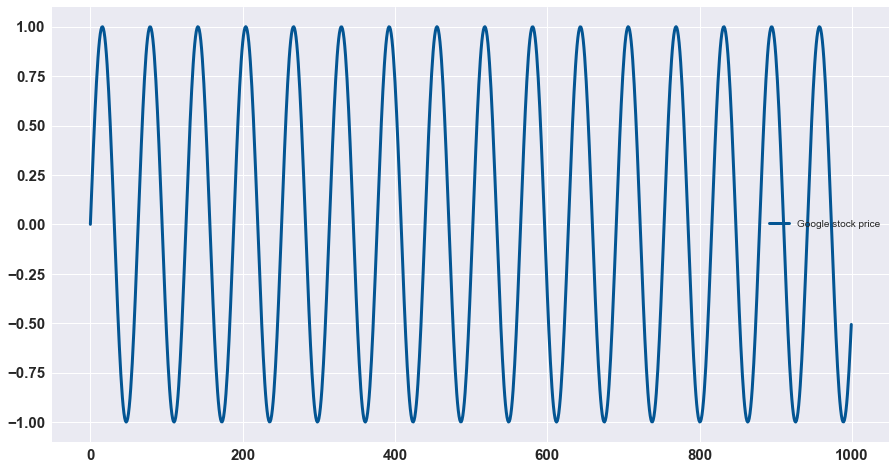

In [3]:
# SEASONAL TIME SERIES 

# Create the data
lin = np.linspace(0,100,1000)
sin = np.sin(lin)


# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(sin, color="#035593", linewidth=3)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.legend(["Google stock price"])
plt.show()

### 7.1.2. Log price properties

In [4]:
# Import the data
df = yf.download("GOOG", end="2021-01-01")["Adj Close"]

[*********************100%***********************]  1 of 1 completed


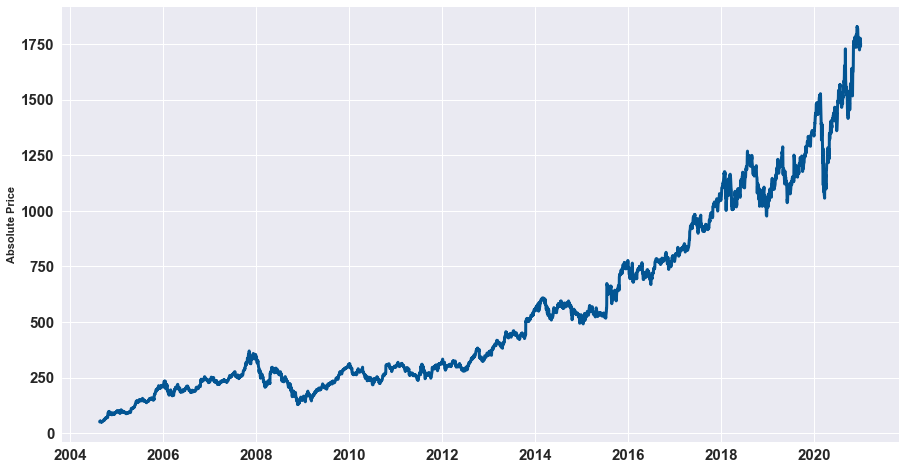

In [5]:
plt.figure(figsize=(15,8))
plt.plot(df, color="#035593", linewidth=3)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.ylabel("Absolute Price",fontweight="bold")
plt.show()

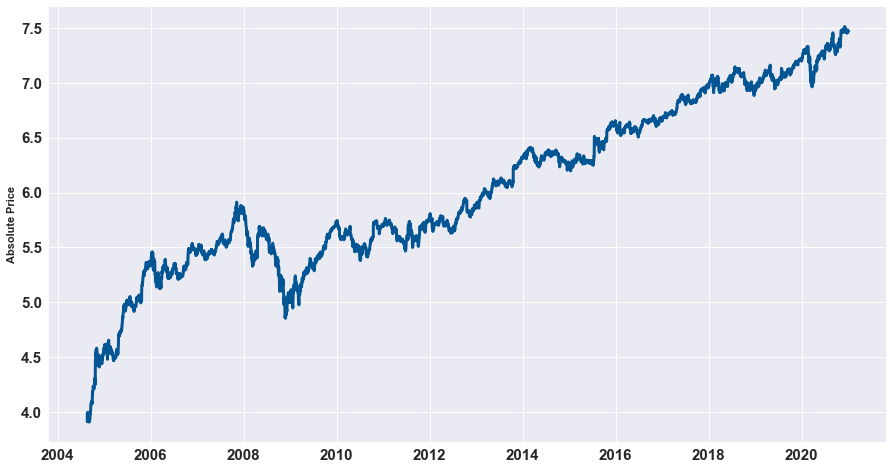

In [6]:
# Plot log price
plt.figure(figsize=(15,8))
plt.plot(np.log(df), color="#035593", linewidth=3)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.ylabel("Absolute Price",fontweight="bold")
plt.show()

### 7.2.1. Autoregressive model (AR)
<br>
Reminder: Now, we work with the EURUSD currency not anymore with Google

In [7]:
# Import EURUSD data

# Compute p value on the absolute values
df = yf.download("EURUSD=X", start = "2017-01-10",end="2021-01-10")[["Adj Close"]].dropna()
print("P-value absolute values:",np.round(adfuller(df["Adj Close"])[1],3))

# Compute p values on the variation percentage values
df = df.pct_change(1).dropna()
print("P-value absolute values:",np.round(adfuller(df["Adj Close"])[1],3))

[*********************100%***********************]  1 of 1 completed
P-value absolute values: 0.358
P-value absolute values: 0.0


In [8]:
def AR_predict_value(train_set):
    """ Function for predict the value of tomorrow using AR model"""

    # Define model
    p = 1
    model = ARIMA(train_set, order=(p, 0, 0))

    # Fit the model
    model_fit = model.fit(disp=0)

    # Make forecast
    forecast = model_fit.forecast()

    return forecast[0][0]


def AR(df,returns=True):
    """ Function to predict the test set with a AR model """

    # Find the split
    split = int(len(df)*0.70)

    # Predict the price using AR function
    df['predicted_value'] = df['Adj Close'].rolling(split).apply(AR_predict_value)

    # Compute the returns of the asset
    if returns:
        df['returns'] = df['Adj Close']
        df['signal'] = np.where(df.predicted_value > 0, 1, -1)
    else:
        df['returns'] = df['Adj Close'].pct_change(1)
        df['signal'] = np.where(df.predicted_value > df['Adj Close'], 1, -1)

    df['strategy'] = df.signal.shift(1) * df.returns

    return df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.021 	 Alpha: -1.13 %	     Sharpe: -0.211 	 Sortino: -0.313
  -----------------------------------------------------------------------------
    VaR: 16.1 %	 cVaR: 18.37 % 	     VaR/cVaR: 1.141 	 drawdown: 10.36 %
  -----------------------------------------------------------------------------


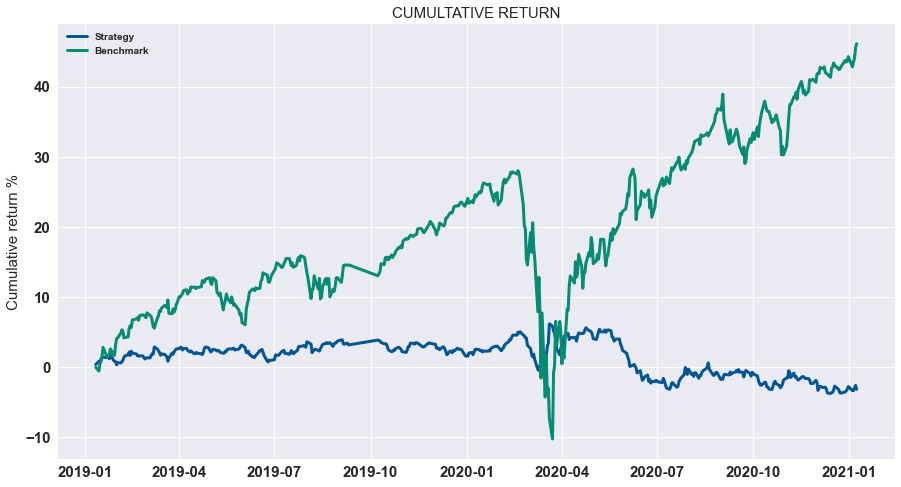

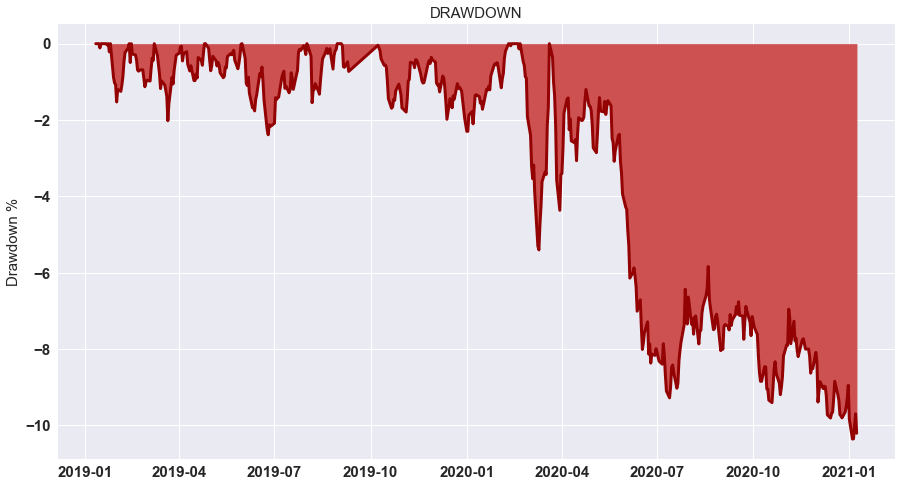

In [10]:
# Import the data
data = yf.download("EURUSD=X",start = "2019-01-10", end="2021-01-10")[["Adj Close"]].pct_change(1).dropna()

# Create the strategy
df = AR(data, returns=True)

# Backtesting
backtest_dynamic_portfolio(df["strategy"])

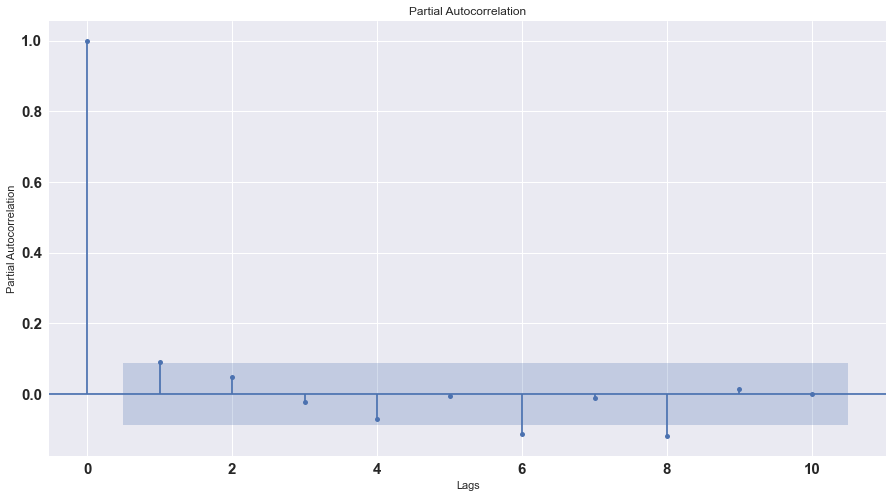

In [11]:
# Plot partial autocorrelation
fig, ax = plt.subplots(figsize=(15, 8))
plot_pacf(df['Adj Close'], lags=10, ax=ax)
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 7.2.2. Moving average model (MA)

In [12]:
def MA_predict_value(train_set):
    """ Function for predict the value of tomorrow using AR model"""

    # Define model
    q = 1
    model = ARIMA(train_set, order=(0, 0, q))

    # Fit the model
    model_fit = model.fit(disp=0)

    # Make forecast
    forecast = model_fit.forecast()

    return forecast[0][0]

  
def MA(df,returns=True):
    """ Function to predict the test set with a MA model """

    # Find the split
    split = int(len(df)*0.70)

    # Predict the price using AR function
    df['predicted_value'] = df['Adj Close'].rolling(split).apply(MA_predict_value)

    # Compute the returns of the asset
    if returns:
        df['returns'] = df['Adj Close']
        df['signal'] = np.where(df.predicted_value > 0, 1, -1)
    else:
        df['returns'] = df['Adj Close'].pct_change(1)
        df['signal'] = np.where(df.predicted_value > df['Adj Close'], 1, -1)

    df['strategy'] = df.signal.shift(1) * df.returns

    return df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.025 	 Alpha: -0.03 %	     Sharpe: 0.023 	 Sortino: 0.035
  -----------------------------------------------------------------------------
    VaR: 14.74 %	 cVaR: 16.83 % 	     VaR/cVaR: 1.142 	 drawdown: 9.04 %
  -----------------------------------------------------------------------------


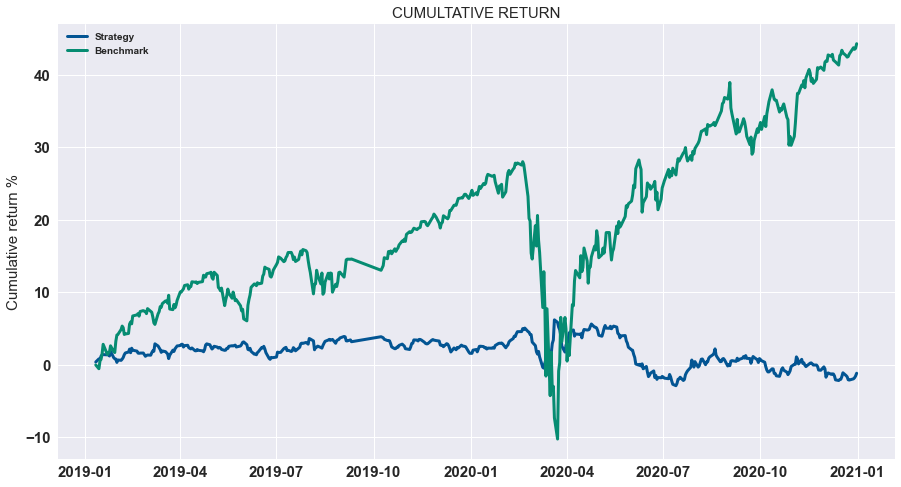

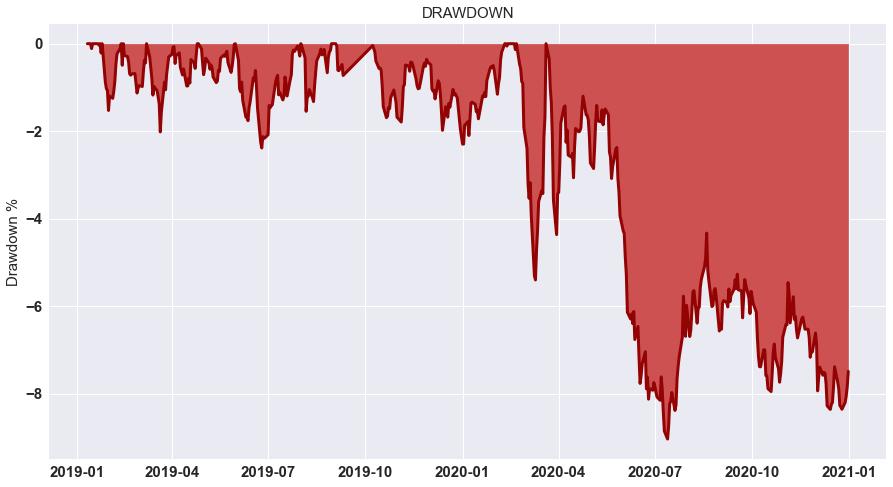

In [13]:
# Import the data
data = yf.download("EURUSD=X",start = "2019-01-10", end="2021-01-01")[["Adj Close"]].pct_change(1).dropna()

# Create the strategy
df = MA(data, returns=True)

# Backtesting
backtest_dynamic_portfolio(df["strategy"])

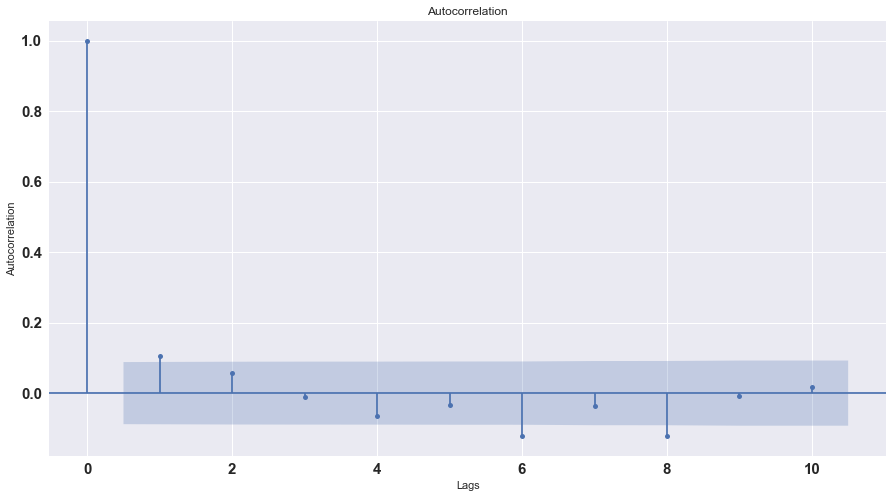

In [14]:
# Plot the autocorrelation
fig, ax = plt.subplots(figsize=(15,8))
plot_acf(df['Adj Close'], lags=10, ax=ax)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 7.3.1. ARMA (stationary data needed)

In [15]:
def ARMA_predict_value(train_set):
    """ Function for predict the value of tomorrow using AR model"""

    # Define model
    p = 1
    q = 1
    model = ARIMA(train_set, order=(p, 0, q))

    # Fit the model
    model_fit = model.fit(disp=0)

    # Make forecast
    forecast = model_fit.forecast()

    return forecast[0][0]

  
def ARMA(df,returns=True):
    """ Function to predict the test set with a ARMA model """

    # Find the split
    split = int(len(df)*0.70)

    # Predict the price using AR function
    df['predicted_value'] = df['Adj Close'].rolling(split).apply(ARMA_predict_value)

    # Shift the predicted price by 1 period
    df['predicted_value'] = df['predicted_value'].shift(1)

    # Compute the returns of the asset
    if returns:
        df['returns'] = df['Adj Close']
        df['signal'] = np.where(df.predicted_value > 0, 1, -1)
    else:
        df['returns'] = df['Adj Close'].pct_change(1)
        df['signal'] = np.where(df.predicted_value > df['Adj Close'], 1, -1)

    df['strategy'] = df.signal.shift(1) * df.returns

    return df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.023 	 Alpha: 1.75 %	     Sharpe: 0.227 	 Sortino: 0.341
  -----------------------------------------------------------------------------
    VaR: 13.47 %	 cVaR: 15.62 % 	     VaR/cVaR: 1.16 	 drawdown: 10.0 %
  -----------------------------------------------------------------------------


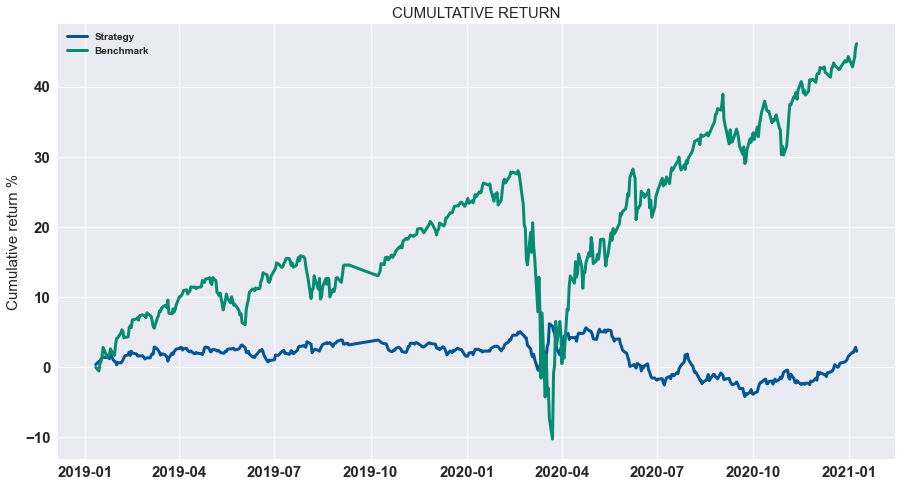

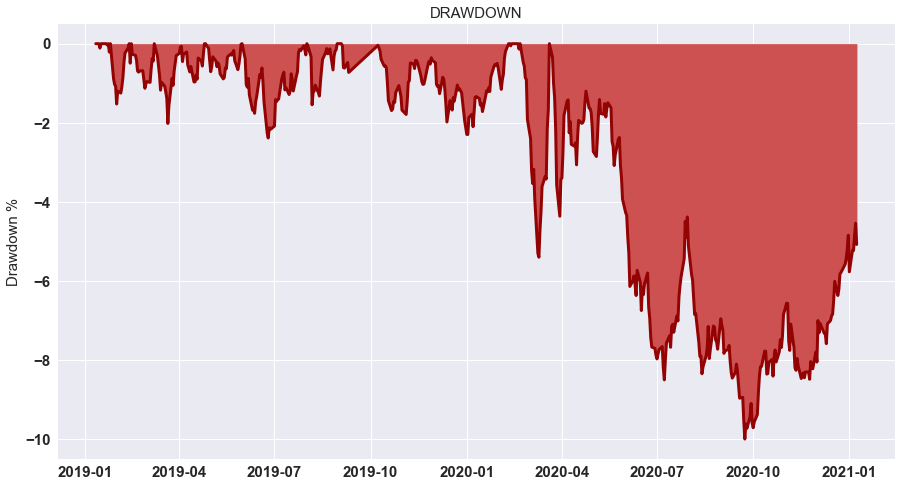

In [16]:
# Import the data
data = yf.download("EURUSD=X",start = "2019-01-10", end="2021-01-10")[["Adj Close"]].pct_change(1).dropna()

# Create the strategy
df = ARMA(data, returns=True)

# Backtesting
backtest_dynamic_portfolio(df["strategy"])

In [17]:
def ARIMA_predict_value(train_set):
    """ Function for predict the value of tomorrow using AR model"""

    # Define model
    p = 1
    q = 1
    d = 1
    model = ARIMA(train_set, order=(p, d, q))

    # Fit the model
    model_fit = model.fit(disp=0)

    # Make forecast
    forecast = model_fit.forecast()

    return forecast[0][0]

  
def ARIMA_model(df,returns=True):
    """ Function to predict the test set ith a ARIMA model """

    # Find the split
    split = int(len(df)*0.70)

    # Predict the price using AR function
    df['predicted_value'] = df['Adj Close'].rolling(split).apply(ARIMA_predict_value)

    # Shift the predicted price by 1 period
    df['predicted_value'] = df['predicted_value'].shift(1)

    # Compute the returns of the asset
    if returns:
        df['returns'] = df['Adj Close']
        df['signal'] = np.where(df.predicted_value > 0, 1, -1)
    else:
        df['returns'] = df['Adj Close'].pct_change(1)
        df['signal'] = np.where(df.predicted_value > df['Adj Close'], 1, -1)

    df['strategy'] = df.signal.shift(1) * df.returns

    return df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.016 	 Alpha: -0.25 %	     Sharpe: 0.103 	 Sortino: 0.16
  -----------------------------------------------------------------------------
    VaR: 14.32 %	 cVaR: 16.46 % 	     VaR/cVaR: 1.149 	 drawdown: 9.6 %
  -----------------------------------------------------------------------------


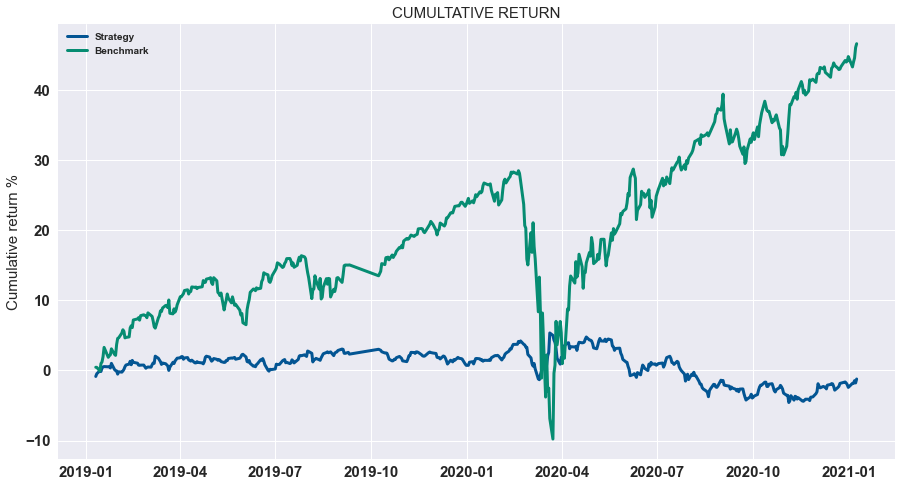

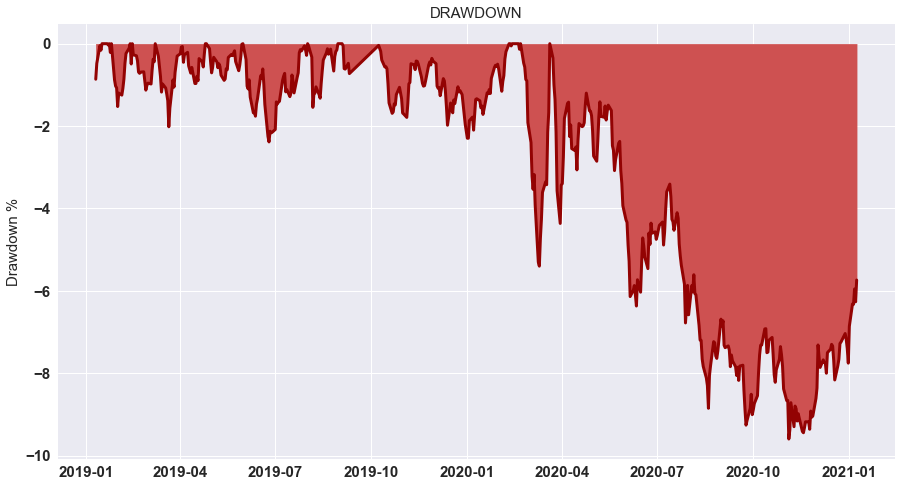

In [18]:
# Import the data
data = yf.download("EURUSD=X",start = "2019-01-10", end="2021-01-10")[["Adj Close"]].dropna()

# Create the strategy
df = ARIMA_model(data, returns=False)

# Backtesting
backtest_dynamic_portfolio(df["strategy"])